In [1]:
from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("ReadParquetExample").config("spark.sql.adaptive.enabled", "true").config("spark.jars","/mnt/c/drivers/postgresql-42.7.8.jar").getOrCreate()
spark = SparkSession.builder.appName("taxi_silver").getOrCreate()
df = spark.read.parquet("../data/dataset.parquet")
# print(spark.sparkContext.getConf().get("spark.jars"))
df.show(5)
df.count()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/09 15:34:40 WARN Utils: Your hostname, DESKTOP-NSV5698, resolves to a loopback address: 127.0.1.1; using 172.25.203.92 instead (on interface eth0)
26/01/09 15:34:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/09 15:35:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

3475226

In [2]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [3]:
from pyspark.sql.functions import unix_timestamp
df = df.withColumn(
    "duration_minutes",
    (unix_timestamp("tpep_dropoff_datetime") -
     unix_timestamp("tpep_pickup_datetime")) / 60
)
# df = df.filter(col("duration_minutes") > 0)
df.select("duration_minutes").show(5)

+-----------------+
| duration_minutes|
+-----------------+
|             8.35|
|             2.55|
|             1.95|
|5.566666666666666|
|3.533333333333333|
+-----------------+
only showing top 5 rows


In [4]:
from pyspark.sql.functions import col, sum 
# Count missing values in each column
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|duration_minutes|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+----------------+
|       0|                   0|                    0|         540149|          

In [5]:
# from pyspark.sql.functions import when

df = df.fillna({
    "passenger_count": 1,
    "RatecodeID": 1,
    "store_and_fwd_flag": "N",
    "congestion_surcharge": 0,
    "Airport_fee": 0
})


In [6]:
df = df.filter(
    (col("duration_minutes") > 0) &
    (col("trip_distance") > 0) &
    (col("trip_distance") <= 200) &
    (col("passenger_count") > 0)
)
# df.select("duration_minutes", "trip_distance", "passenger_count").show(5)

In [7]:
from pyspark.sql.functions import hour, dayofweek, month

df = df.withColumn("pickuphour", hour("tpep_pickup_datetime"))
df = df.withColumn("dayof_week", dayofweek("tpep_pickup_datetime"))
df = df.withColumn("month", month("tpep_pickup_datetime"))
# df.select("pickuphour", "dayof_week", "month").show(5)

In [8]:
df.printSchema()
df.show(5)
# La table Silver garantit des colonnes clés non nulles et prêtes pour l’exploitation.

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = false)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = false)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = false)
 |-- Airport_fee: double (nullable = false)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- duration_minutes: double (nullable = true)
 |-- pickuphour: intege

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------------+----------+----------+-----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee| duration_minutes|pickuphour|dayof_week|month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------------+----------+----------

In [9]:
rows_before = df.count()
df = df.dropDuplicates()
rows_after = df.count()

print("Rows before:", rows_before)
print("Rows after:", rows_after)
print("Nombre de doublons supprimés:", rows_before - rows_after)


Rows before: 3359200
Rows after: 3359200
Nombre de doublons supprimés: 0


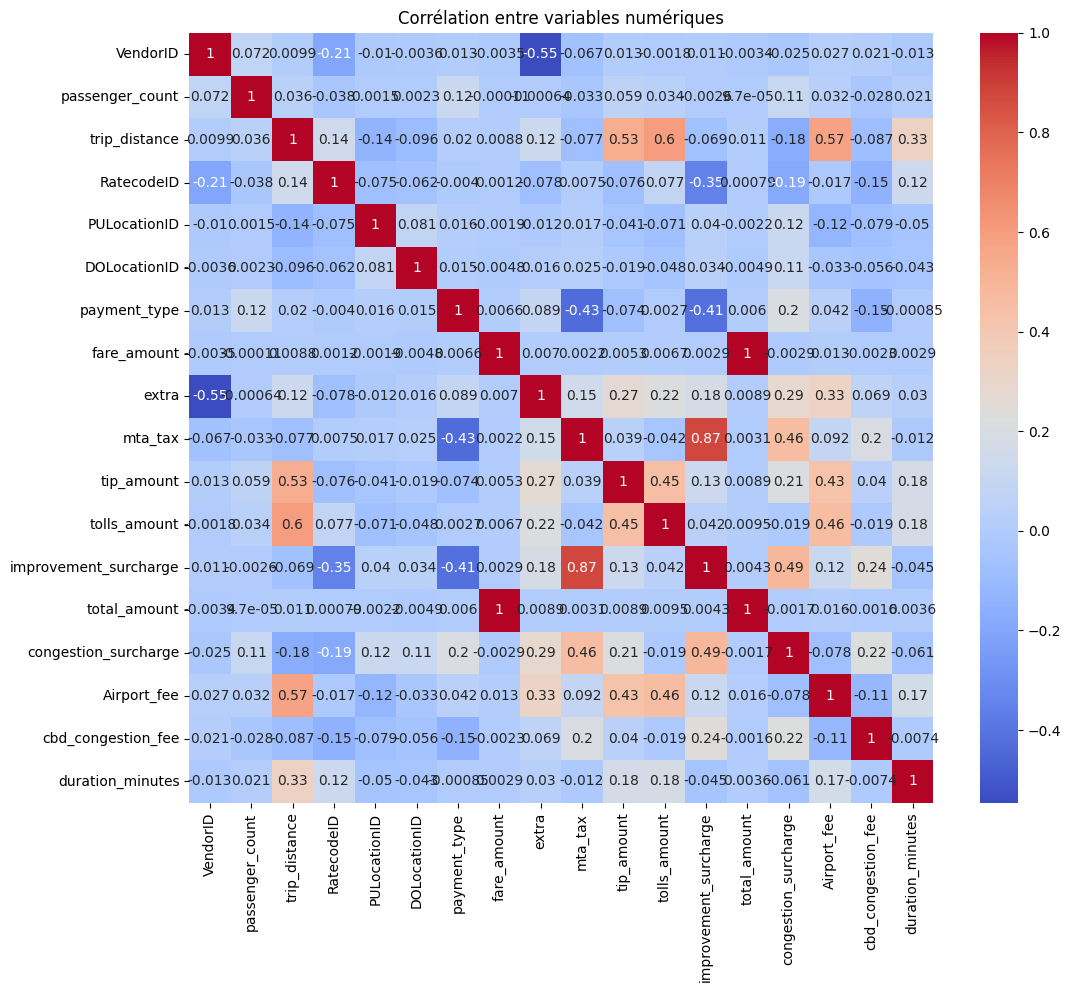

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_cols = [
    "VendorID",
    "passenger_count",
    "trip_distance",
    "RatecodeID",
    "PULocationID",
    "DOLocationID",
    "payment_type",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
    "cbd_congestion_fee",
    "duration_minutes"
]
# data claud -> stumeler airflow streaming / kafka spark hadoop big data live data 

pdf = df.select(numeric_cols).sample(withReplacement=False, fraction=0.1).toPandas()
corr = pdf.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr,annot=True,cmap="coolwarm")
plt.title("Corrélation entre variables numériques")
plt.show()


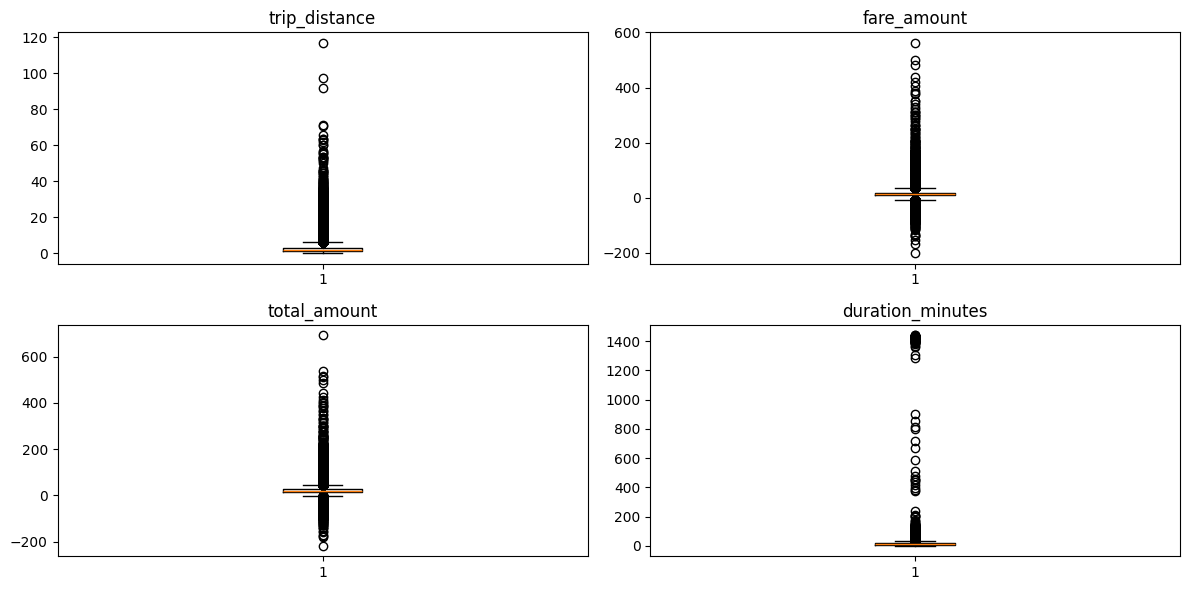

In [11]:
# Gérer les outliers


# Échantillon depuis Spark
sample_pdf = df.select(
    "trip_distance", "fare_amount", "total_amount", "duration_minutes"
).sample(fraction=0.05, seed=42).toPandas()

import matplotlib.pyplot as plt

cols = ["trip_distance", "fare_amount", "total_amount", "duration_minutes"]

plt.figure(figsize=(12, 6))
for i, c in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(sample_pdf[c].dropna())
    plt.title(c)

plt.tight_layout()
plt.show()


In [12]:
from pyspark.sql.functions import col
from utils import remove_outliers_iqr

for c in ["trip_distance", "fare_amount", "total_amount", "duration_minutes"]:
    df = remove_outliers_iqr(df, c, k=1.5)
df.count()

trip_distance -> Q1=1.01, Q3=3.12, IQR=2.1100000000000003, bounds=(-2.1550000000000002, 6.285)


fare_amount -> Q1=7.9, Q3=16.3, IQR=8.4, bounds=(-4.700000000000001, 28.900000000000002)


total_amount -> Q1=15.2, Q3=23.9, IQR=8.7, bounds=(2.1500000000000004, 36.949999999999996)


duration_minutes -> Q1=6.7, Q3=14.616666666666667, IQR=7.916666666666667, bounds=(-5.175, 26.491666666666667)


2680025

In [13]:
df.coalesce(1).write.mode("overwrite").parquet("../data/silver_taxi_data")


In [14]:
import pandas as pd

df = pd.read_parquet(
    r"/mnt/c/Users/hp/OneDrive/Desktop/Simplon_project/Project-Smart-LogiTrack-/data/silver_taxi_data"
)
print(df.shape)
print(df.head())


(2680025, 24)
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2025-01-01 00:17:12   2025-01-01 00:21:57                3   
1         2  2025-01-01 00:38:34   2025-01-01 00:48:04                1   
2         2  2025-01-01 00:36:20   2025-01-01 00:38:30                1   
3         1  2025-01-01 00:11:08   2025-01-01 00:33:13                1   
4         1  2025-01-01 00:57:51   2025-01-01 01:09:20                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.46           1                  N           263           141   
1           1.20           1                  N           164           233   
2           0.48           1                  N           151           238   
3           2.60           1                  N           114           162   
4           1.50           1                  N           170           113   

   payment_type  ...  tolls_amount  improvement_surcharge  t

In [18]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
spark = SparkSession.builder.appName("taxi_model_training").getOrCreate()
df = spark.read.parquet("../data/silver_taxi_data")

target = "duration_minutes"
features = [
        "pickuphour",
        "dayof_week",
        "month",
        "congestion_surcharge",
        "trip_distance",
        "PULocationID",
        "DOLocationID",
        "cbd_congestion_fee",
        "total_amount"
]
assembler = VectorAssembler(inputCols=features, outputCol="features")

rf = RandomForestRegressor(featuresCol="features", labelCol=target, numTrees=100, maxDepth=10, seed=42)

pipeline = Pipeline(stages=[assembler, rf])

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)



26/01/09 16:30:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
26/01/09 16:30:50 WARN MemoryStore: Not enough space to cache rdd_189_1 in memory! (computed 344.7 MiB so far)
26/01/09 16:30:50 WARN BlockManager: Persisting block rdd_189_1 to disk instead.
26/01/09 16:31:32 WARN MemoryStore: Not enough space to cache rdd_189_1 in memory! (computed 344.7 MiB so far)
26/01/09 16:32:16 WARN MemoryStore: Not enough space to cache rdd_189_1 in memory! (computed 344.7 MiB so far)
26/01/09 16:33:16 WARN MemoryStore: Not enough space to cache rdd_189_1 in memory! (computed 344.7 MiB so far)
26/01/09 16:34:36 WARN MemoryStore: Not enough space to cache rdd_189_1 in memory! (computed 344.7 MiB so far)
26/01/09 16:36:15 WARN MemoryStore: Not enough space to cache rdd_189_1 in memory! (computed 344.7 MiB so far)
26/01/09 16:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1038.3 KiB
26/01/09 16:38:33 WARN MemoryStore: Not enough space to cache rdd_189_1 in mem

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator

mae_evaluator = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="mae"
)
mae = mae_evaluator.evaluate(predictions)

# R²
r2_evaluator = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="r2"
)
r2 = r2_evaluator.evaluate(predictions)

print(f"Mean Absolute Error (MAE) on test data = {mae:.4f}")
print(f"R² on test data = {r2:.4f}")

Mean Absolute Error (MAE) on test data = 1.6677
R² on test data = 0.8270


In [20]:
# Sauvegarder le pipeline complet
model.save("../models/taxi_duration_model")
print("Model saved successfully!")


26/01/09 17:30:22 WARN TaskSetManager: Stage 120 contains a task of very large size (10066 KiB). The maximum recommended task size is 1000 KiB.


Model saved successfully!
